In [1]:
import os
os.chdir("../")

In [2]:
import warnings
import numpy as np
import jax.numpy as jnp
from scipy import signal

import matplotlib.pyplot as plt
from matplotlib import rcParams as rc
configs = {
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    # 'font.sans-serif': ['Microsoft YaHei', 'SimHei', 'Arial', 'Liberation Sans', 'sans-serif'],
    'font.sans-serif': ['Palatino Linotype', 'Microsoft YaHei', 'SimHei', 'Arial', 'Liberation Sans', 'sans-serif'],
    'axes.grid': True,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'mathtext.fontset': "cm",
    # 'mathtext.rm': "asana math",
    # 'mathtext.cal': "asana math",
    "font.size": 16,
    # 'axes.labelsize': 'large',
    # 'axes.labelpad': 8.0,
    # 'xtick.major.pad': 9.0,
}
rc.update(configs)


import matplotlib.font_manager
font_path = "/home/nanxi/.local/share/fonts/Palatino-Linotype-Regular.ttf"
if os.path.exists(font_path):
    matplotlib.font_manager.fontManager.addfont(font_path)
    prop = matplotlib.font_manager.FontProperties(fname=font_path)
    plt.rcParams['font.family'] = prop.get_name()
    print(f"Set font to {prop.get_name()}")

Set font to Palatino Linotype


In [3]:
def calculate_measured_psd(data, fs=1/6, return_ref=False, direction="along"):
    # u_bar = np.sqrt(np.mean(ux)**2 + np.mean(uy)**2)
    frequencies, psd = signal.welch(data, fs=fs, window='hamming', 
                                   scaling='density', nperseg=1024)
    frequencies = frequencies[1:]
    psd = psd[1:]
    if not return_ref:
        return frequencies, psd

In [4]:
import pandas as pd
data = pd.read_csv("./data/data7s(1)/data7s/real_320704039_20220101.csv", encoding="gbk")
u = data["风速"].values
beta = data["风向角"].values
ux = u * np.cos(np.deg2rad(beta))
uy = u * np.sin(np.deg2rad(beta))
u_bar = np.sqrt(np.mean(ux)**2 + np.mean(uy)**2)
beta_bar = np.arctan2(np.mean(uy), np.mean(ux))
uu =  ux * np.cos(beta_bar) + uy * np.sin(beta_bar) - u_bar
vv = -ux * np.sin(beta_bar) + uy * np.cos(beta_bar)

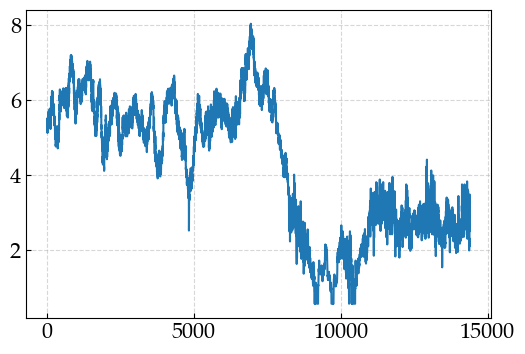

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(u)

In [6]:
frequencies, psd = calculate_measured_psd(u, return_ref=False, fs=1/6)
z = 140
z0 = 0.01
H_ = 0
K = 0.4
zd = H_ - z0 / K
u_star = K * u_bar / np.log((z - zd) / z0)
f = frequencies * z / u_bar
reference_psd = 200 * f / (1 + 50 * f)**(5/3) * u_star**2 / frequencies
u10 = u_bar * (10 / z) ** 0.12
fs = 1/6

In [7]:
fs/2

0.08333333333333333

In [8]:
from stochastic_wind_simulate import get_simulator, get_visualizer
simulator = get_simulator(backend="jax", key=42, spectrum_type="kaimal-nd")
simulator.update_parameters(
    H_bar=H_,
    z_0=z0,
    T=3600,
    M=6000,
    N=3000,
    dt=6,
    U_d=u10,
    alpha_0=0.12,
    w_up=fs/2,
)

n = 50
Z = z
position = np.zeros((n, 3))
position[:, 2] = np.linspace(200, Z, n)
position[:, 0] = 0
position[:, 1] = 0
wind_speeds = u10 * (jnp.minimum(position[:, 2], z) / 10) ** 0.12
samples, frequencies_sim = simulator.simulate_wind(
    position, wind_speeds, component="u"
)
frequencies_sim, psd_sim = signal.welch(samples[-1], fs=fs, window='hamming', 
                                   scaling='density', nperseg=1024)

[Text(0.5, 0, 'Frequency (Hz)'),
 Text(0, 0.5, 'Power Spectral Density (m$^2$/s)')]

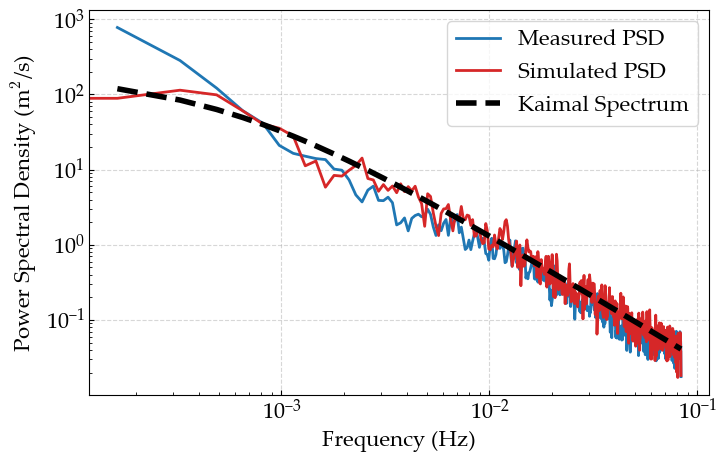

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.loglog(frequencies, psd, label="Measured PSD", color="C0", lw=2)
ax.loglog(frequencies_sim, psd_sim, label="Simulated PSD", color="C3", linestyle="solid", lw=2)
ax.loglog(frequencies, reference_psd, label="Kaimal Spectrum", color="black", linestyle="--", lw=4)
ax.legend()
ax.set(xlabel="Frequency (Hz)", ylabel="Power Spectral Density (m$^2$/s)")
# fig.savefig("./img/offshore_wind_simulation.png", dpi=300, bbox_inches="tight")
# fig.savefig("./img/offshore_wind_simulation.pdf", dpi=300, bbox_inches="tight")
